In [91]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


import copy
import torch
import tqdm
import torch.nn as nn
import torch.optim as optim



In [92]:
# PREPOCESAMIENTO DE DATOS


# cargar dataset
df_part = pd.read_csv('../../data/partidos_train_ucl_23_todo_24_fg_PROP.csv')
df_part.set_index('Match_ID', inplace=True)

# seleccionar variables de interes
df_1 = df_part.copy()
variables = df_1.drop(['Nombre_Eq1','Nombre_Eq2','GANADOR','Year'], axis=1).columns.to_list()
df_1 = df_1[variables]


# ampliar dataset (x4) para ML
df_3 = df_1.copy()
for _ in range(2):
    df_3 = pd.concat([df_3, df_3], axis=0)

print('DATOS LISTOS')
print()




# DIVIDIR TEST Y TRAIN
df_4 = df_3.copy()
caracteristicas = df_4.drop(['Gol_Match_Eq1', 'Gol_Match_Eq2'], axis=1).columns.to_list()
objetivo = ['Gol_Match_Eq1', 'Gol_Match_Eq2']

data_caract = df_4[caracteristicas].values
data_obj = df_4[objetivo].values

# División entrenamiento-prueba para evaluación del modelo
X_train, X_test, y_train, y_test = train_test_split(data_caract, data_obj, train_size=0.7, shuffle=True)


# escalar datos variables independientes
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


# Convertir a tensores 2D de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 2)  # Asegurarse de que y_train tenga 2 columnas
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 2)  # Asegurarse de que y_test tenga 2 columnas


print('DATOS TEST Y TRAIN LISTOS')
print()

DATOS LISTOS

DATOS TEST Y TRAIN LISTOS



In [93]:
len(caracteristicas)

34

In [94]:
# Definir el modelo
UCL_model = nn.Sequential(
    nn.Linear(len(caracteristicas), 200),  # Entrada de 32 características
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 2)  # Salida de 2 variables objetivo
)

# Función de pérdida y optimizador
loss_fn = nn.MSELoss()  # Error cuadrático medio
optimizer = optim.Adam(UCL_model.parameters(), lr=0.0001)

n_epochs = 50   # numero epochs
batch_size = 10  # tamaño del conjunto de actualizacion de pesos
batch_start = torch.arange(0, len(X_train), batch_size)


# Guardar el mejor modelo
best_mse = np.inf
best_weights = None
history = []


for epoch in range(n_epochs):
    UCL_model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            end = min(start + batch_size, len(X_train))  # Ajuste para el último lote
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            # Paso hacia adelante
            y_pred = UCL_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Paso hacia atrás
            optimizer.zero_grad()
            loss.backward()
            # Actualizar pesos
            optimizer.step()
            bar.set_postfix(mse=float(loss))
    # Evaluar precisión al final de cada época
    UCL_model.eval()
    y_pred = UCL_model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(UCL_model.state_dict())

# Restaurar modelo a la mejor precisión
UCL_model.load_state_dict(best_weights)


<All keys matched successfully>

MSE: 1.21
RMSE: 1.10


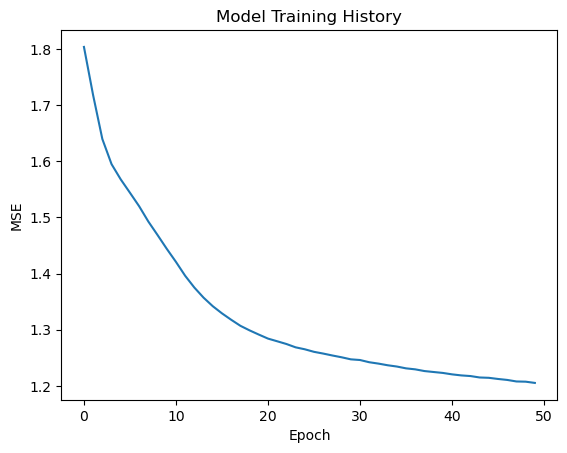

In [95]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model Training History')
plt.show()

In [96]:
# Save the model weights
model_file = 'goal_regression_dnn_P_2.pth'
torch.save(UCL_model.state_dict(), model_file)
#del UCL_model
print('model saved as', model_file)

model saved as goal_regression_dnn_P_2.pth


## Predicciones

In [97]:
def predecir_resultado(model, feature_vector):
    
    model.eval()  # Poner el modelo en modo de evaluación
    # Convertir el vector de características a tensor de PyTorch
    # Asegúrate de que el vector de entrada sea de tipo float32
    if isinstance(feature_vector, list):
        feature_vector = np.array(feature_vector)
    feature_tensor = torch.tensor(feature_vector, dtype=torch.float32).unsqueeze(0)  # Añadir una dimensión batch
    
    with torch.no_grad():  # Desactivar el seguimiento de gradientes
        predictions = model(feature_tensor)  # Obtener las predicciones del modelo
        # Convertir las predicciones a un array de numpy para facilitar su manipulación
        predictions = predictions.numpy()
        
    return predictions


def resultado_media_final(eq1, eq2):
    '''media de partido de ida y de vuelta'''
    eq1_eq2 = predecir_resultado(UCL_model, eq1+eq2)[0]
    eq2_eq1 = predecir_resultado(UCL_model, eq2+eq1)[0]
    goles_eq1 = [eq1_eq2[0], eq2_eq1[1]]
    goles_eq2 = [eq1_eq2[1], eq2_eq1[0]]

    media_eq1 = np.mean(goles_eq1).round(3)
    media_eq2 = np.mean(goles_eq2).round(3)

    return media_eq1, media_eq2


def resultado_acumulado(eq1, eq2):
    '''media de partido de ida y de vuelta'''
    eq1_eq2 = predecir_resultado(UCL_model, eq1+eq2)[0]
    eq2_eq1 = predecir_resultado(UCL_model, eq2+eq1)[0]
    goles_eq1 = [eq1_eq2[0], eq2_eq1[1]]
    goles_eq2 = [eq1_eq2[1], eq2_eq1[0]]

    sum_eq1 = np.sum(goles_eq1).round(3)
    sum_eq2 = np.sum(goles_eq2).round(3)

    return sum_eq1, sum_eq2


def imprimir_resultados(eq1, eq2):
    print('Resultado IDA:', predecir_resultado(UCL_model, eq1+eq2))
    print('Resultado VUELTA:', predecir_resultado(UCL_model, eq2+eq1))
    print('Resultado acumulado:', resultado_acumulado(eq1, eq2))
    print('Media Goles:', resultado_media_final(eq1, eq2))

### Octavos

In [98]:
psg = [1.55,1.13,2.68,1.4,2.53,23.48,2.57,13.07,4.39,0.25,0.08,0.23,0.86,0.54,3.82,0.19,0.0]
real_soc = [0.82,0.54,1.36,0.8,1.34,16.7,1.31,9.38,3.03,0.22,0.06,0.18,0.49,0.51,2.48,0.25,0.0]

imprimir_resultados(psg, real_soc)

Resultado IDA: [[0.5600427  0.80698436]]
Resultado VUELTA: [[0.732426  1.6629282]]
Resultado acumulado: (2.223, 1.539)
Media Goles: (1.111, 0.77)


In [99]:
copenh = [1.18,0.8,1.97,1.08,1.87,17.35,2.04,9.58,3.3,0.26,0.08,0.25,1.12,0.52,4.42,0.0,0.0]
city = [2.09,1.56,3.65,1.82,3.38,26.29,3.86,14.26,5.28,0.28,0.1,0.26,0.68,0.48,2.23,0.31,0.08]

imprimir_resultados(copenh, city)

Resultado IDA: [[1.0158961 2.410115 ]]
Resultado VUELTA: [[0.8827264 0.7592326]]
Resultado acumulado: (1.775, 3.293)
Media Goles: (0.888, 1.646)


In [100]:
barca = [1.39,1.26,2.66,1.38,2.64,21.04,2.44,12.06,4.15,0.26,0.09,0.25,0.67,0.53,2.53,0.52,0.15]
napoli = [1.02,0.53,1.55,0.9,1.43,19.86,1.74,10.84,3.28,0.23,0.06,0.21,1.0,0.52,3.78,0.0,0.0]

imprimir_resultados(barca, napoli)

Resultado IDA: [[0.79894066 1.0333561 ]]
Resultado VUELTA: [[0.5103296 1.599261 ]]
Resultado acumulado: (2.398, 1.544)
Media Goles: (1.199, 0.772)


In [101]:
atl_mad = [1.56,1.01,2.57,1.53,2.54,18.95,2.47,10.24,3.66,0.27,0.12,0.32,0.79,0.56,3.46,0.33,0.0]
inter = [1.22,0.77,1.99,0.94,1.71,19.86,2.07,10.88,3.47,0.24,0.06,0.2,0.58,0.6,3.11,0.38,0.13]

imprimir_resultados(atl_mad, inter)

Resultado IDA: [[0.7928674 1.3948872]]
Resultado VUELTA: [[0.4592783 1.391268 ]]
Resultado acumulado: (2.184, 1.854)
Media Goles: (1.092, 0.927)


In [102]:
dortmund = [1.17,0.92,2.09,1.03,1.95,19.19,2.12,10.7,3.58,0.25,0.07,0.21,0.57,0.6,2.74,0.19,0.05]
psv = [1.12,0.75,1.87,0.95,1.7,21.29,1.98,11.64,4.12,0.27,0.06,0.16,1.09,0.46,3.06,0.1,0.03]

imprimir_resultados(dortmund, psv)

Resultado IDA: [[0.8054871 1.2656524]]
Resultado VUELTA: [[0.49465725 1.1898752 ]]
Resultado acumulado: (1.995, 1.76)
Media Goles: (0.998, 0.88)


In [103]:
bay_munch = [1.28,1.0,2.28,1.18,2.18,19.23,2.11,10.82,3.2,0.22,0.08,0.28,0.7,0.57,2.74,0.51,0.15]
lazio = [0.78,0.5,1.28,0.62,1.12,15.22,1.35,8.49,2.48,0.22,0.06,0.19,0.91,0.52,3.56,0.0,0.0]

imprimir_resultados(bay_munch, lazio)

Resultado IDA: [[0.4970596 0.8349211]]
Resultado VUELTA: [[0.50484145 1.5545844 ]]
Resultado acumulado: (2.052, 1.34)
Media Goles: (1.026, 0.67)


In [104]:
arsenal = [1.6,1.26,2.86,1.49,2.75,16.63,2.76,9.26,3.58,0.29,0.12,0.32,0.65,0.55,2.66,0.1,0.0]
porto = [1.66,1.23,2.88,1.53,2.77,18.7,2.67,10.46,4.36,0.32,0.11,0.26,0.88,0.53,3.11,0.08,0.05]

imprimir_resultados(arsenal, porto)

Resultado IDA: [[0.8979963 1.6440495]]
Resultado VUELTA: [[0.70660233 1.4984937 ]]
Resultado acumulado: (2.396, 2.351)
Media Goles: (1.198, 1.175)


In [105]:
real_mad = [1.57,1.35,2.92,1.53,2.88,24.5,2.98,13.2,4.48,0.22,0.08,0.23,0.58,0.54,3.3,0.6,0.26]
lepizig = [1.21,1.06,2.27,1.18,2.25,17.27,2.04,10.46,3.61,0.23,0.07,0.22,0.92,0.42,3.08,0.2,0.0]

imprimir_resultados(real_mad, lepizig)

Resultado IDA: [[0.6020666 1.0254492]]
Resultado VUELTA: [[0.9136587 1.9400924]]
Resultado acumulado: (2.542, 1.939)
Media Goles: (1.271, 0.97)


### Cuartos

In [106]:
imprimir_resultados(dortmund, atl_mad)

Resultado IDA: [[0.5370789 1.3489716]]
Resultado VUELTA: [[0.7924247 1.4111427]]
Resultado acumulado: (1.948, 2.141)
Media Goles: (0.974, 1.071)


In [107]:
imprimir_resultados(psg,barca)

Resultado IDA: [[0.6528162 1.4248435]]
Resultado VUELTA: [[0.9028679 1.5467561]]
Resultado acumulado: (2.2, 2.328)
Media Goles: (1.1, 1.164)


In [108]:
imprimir_resultados(arsenal,bay_munch)

Resultado IDA: [[0.96868885 1.4140285 ]]
Resultado VUELTA: [[0.49662796 1.4069992 ]]
Resultado acumulado: (2.376, 1.911)
Media Goles: (1.188, 0.955)


In [109]:
imprimir_resultados(real_mad, city)

Resultado IDA: [[1.0725222 1.8851248]]
Resultado VUELTA: [[1.0951154 1.3695166]]
Resultado acumulado: (2.442, 2.98)
Media Goles: (1.221, 1.49)


### Semis

In [113]:
imprimir_resultados(barca, atl_mad)

Resultado IDA: [[0.6325861 1.3101188]]
Resultado VUELTA: [[0.85842234 1.6619607 ]]
Resultado acumulado: (2.295, 2.169)
Media Goles: (1.147, 1.084)


In [111]:
imprimir_resultados(arsenal, city)

Resultado IDA: [[1.3871022 2.175366 ]]
Resultado VUELTA: [[0.873504   0.91437143]]
Resultado acumulado: (2.301, 3.049)
Media Goles: (1.151, 1.524)


### Final

In [114]:
imprimir_resultados(barca,city)

Resultado IDA: [[1.1237178 1.953577 ]]
Resultado VUELTA: [[1.0025316 1.1027664]]
Resultado acumulado: (2.226, 2.956)
Media Goles: (1.113, 1.478)
